# Imports and Global Variables

## Imports

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
from PIL import Image

## Global Variables

### Directories

In [3]:
test_dir = "../data/chest_xray/test"
train_dir = "../data/chest_xray/train"

### Parameters

# Utility Functions

In [ ]:
def create_dataframe(directory, dataset_type):
    data = []
    
    # Iterate through normal and pneumonia folders
    for label in ['NORMAL', 'PNEUMONIA']:
        folder_path = directory +"/" +label
        if os.path.exists(folder_path):
            for img_file in os.scandir(folder_path):
                if img_file.is_file():
                    data.append({
                        'image_name': img_file.name,
                        'image_path': folder_path + "/" + img_file.name,
                        'has_pneumonia': 1 if label == 'PNEUMONIA' else 0,
                        'dataset': dataset_type
                    })
    
    return pd.DataFrame(data)


def exif_transpose(im):
    try:
        return ImageOps.exif_transpose(im)
    except Exception:
        return im

def image_stats(im):
    im = exif_transpose(im)
    if im.mode not in ("RGB", "L"):
        im = im.convert("RGB")
    arr = np.asarray(im)
    if arr.ndim == 2:  # L
        arr = arr.astype(np.float32) / 255.0
        return {
            "mode": "L",
            "w": im.width, "h": im.height,
            "aspect": im.width / im.height,
            "min": float(arr.min()), "max": float(arr.max()),
            "mean": float(arr.mean()), "std": float(arr.std()),
        }
    else:
        arr = arr.astype(np.float32) / 255.0
        flat = arr.reshape(-1, 3)
        return {
            "mode": "RGB",
            "w": im.width, "h": im.height,
            "aspect": im.width / im.height,
            "min": [float(flat[:,0].min()), float(flat[:,1].min()), float(flat[:,2].min())],
            "max": [float(flat[:,0].max()), float(flat[:,1].max()), float(flat[:,2].max())],
            "mean": [float(flat[:,0].mean()), float(flat[:,1].mean()), float(flat[:,2].mean())],
            "std": [float(flat[:,0].std()), float(flat[:,1].std()), float(flat[:,2].std())],
        }


# Splitting Train and Test Data

In [5]:
train_df = create_dataframe(train_dir, 'train')
test_df = create_dataframe(test_dir, 'test')

In [13]:
#export dataframes to csv
train_df.to_csv('../data/chest_xray/train/train_labels.csv', index=False)
test_df.to_csv('../data/chest_xray/test/test_labels.csv', index=False)

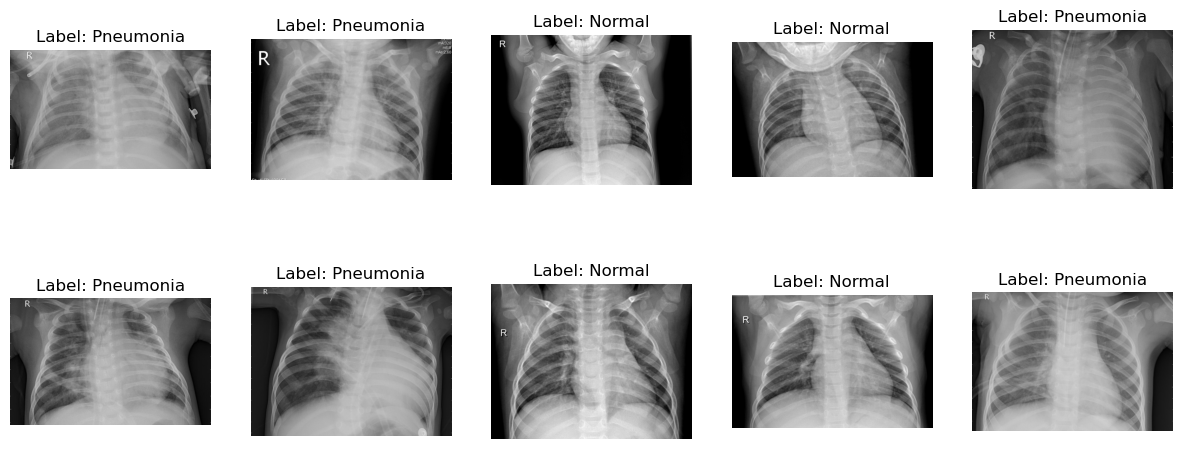

In [ ]:
#randomly grab 10 samples from train and display
sampled_df = train_df.sample(n=10, random_state=42).reset_index(drop=True)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = Image.open(sampled_df.loc[i, 'image_path'])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {'Pneumonia' if sampled_df.loc[i, 'has_pneumonia'] == 1 else 'Normal'}")
    ax.axis('off')

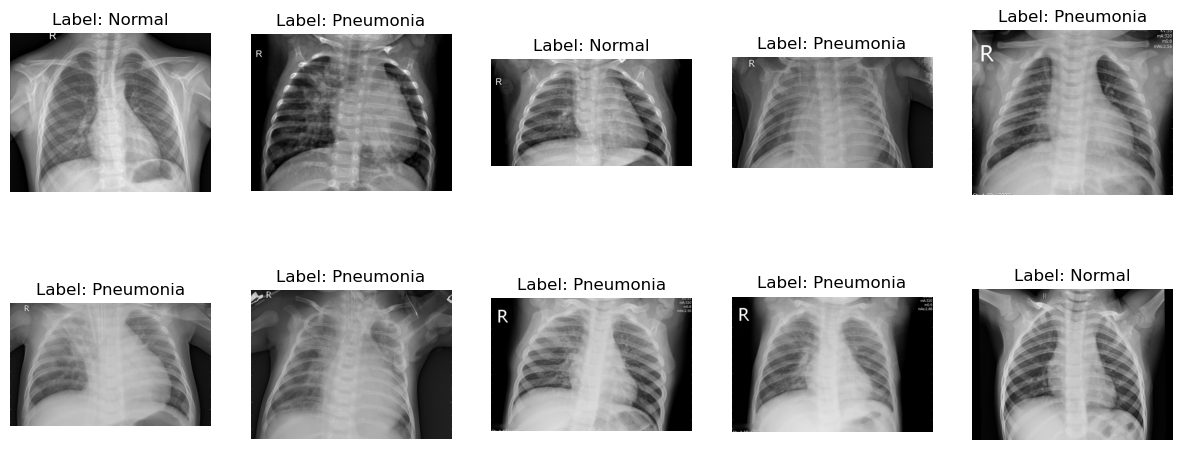

In [9]:
#randomly grab 10 samples from test and display
sampled_df = test_df.sample(n=10, random_state=42).reset_index(drop=True)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    img = Image.open(sampled_df.loc[i, 'image_path'])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {'Pneumonia' if sampled_df.loc[i, 'has_pneumonia'] == 1 else 'Normal'}")
    ax.axis('off')

In [12]:
train_df.head()

,image_name,image_path,has_pneumonia,dataset
0,IM-0115-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg,0,train
1,IM-0117-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg,0,train
2,IM-0119-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg,0,train
3,IM-0122-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0122-0001.jpeg,0,train
4,IM-0125-0001.jpeg,../data/chest_xray/train/NORMAL/IM-0125-0001.jpeg,0,train


In [11]:
test_df.head()

,image_name,image_path,has_pneumonia,dataset
0,IM-0001-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg,0,test
1,IM-0003-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0003-0001.jpeg,0,test
2,IM-0005-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0005-0001.jpeg,0,test
3,IM-0006-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0006-0001.jpeg,0,test
4,IM-0007-0001.jpeg,../data/chest_xray/test/NORMAL/IM-0007-0001.jpeg,0,test


# Exploratory Data Analysis

## Class balance

<Axes: xlabel='has_pneumonia'>

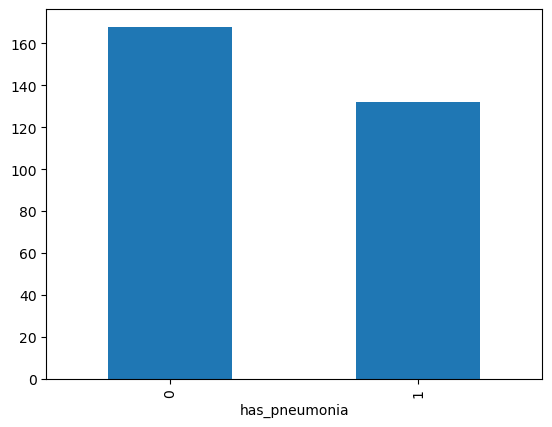

In [6]:
train_df['has_pneumonia'].value_counts().plot(kind='bar')

<Axes: xlabel='has_pneumonia'>

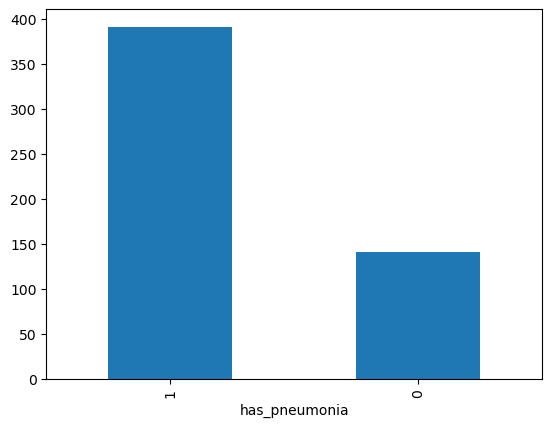

In [7]:
test_df['has_pneumonia'].value_counts().plot(kind='bar')

## Image Characteristics